In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                             shuffle=True, random_state=42, 
                             categories=[
                                 'comp.graphics',
                                 'soc.religion.christian',
                                 'talk.politics.guns', 
                                 'misc.forsale'
                             ])

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

3855 documents
4 categories


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess

df = pd.DataFrame({'text': dataset.data, 'target': dataset.target}).copy()
df['target_name'] = df.target.apply(lambda x: dataset.target_names[x])
df.text = df.text.apply(lambda x: ' '.join(simple_preprocess(x)))


In [3]:
print(df.text.values[0])
df.head()


we also cannot fail to note the intense suffering devastation which has been wrecked on our world because of christians who were certain they were following christ from captialist who have polluted the enviorment in strict obedience to the gensis command to subdue the earth to nazi who have justly punished the jews for the killing christ as well as the other progroms the innocent women who were burned alive in accordance with you shall not allow witch to live the moslems who were killed in the crusades the god fearing men destroyed by the inquistion the religious wars in spain france england etc christianity has undoubtedly caused the most suffering and needless loss of life by individuals whose certainity that they were following the instructions therein was unquestionable there is much to grieve


,text,target,target_name
0,we also cannot fail to note the intense suffer...,2,soc.religion.christian
1,reduced prices have list of things forsale on ...,1,misc.forsale
2,archive name graphics resources list part last...,0,comp.graphics
3,nova mob last days of pompeii ppd overwhelming...,1,misc.forsale
4,no surrender delivered by lenda jackson at the...,3,talk.politics.guns


In [4]:
df['text_word_count'] = df['text'].apply(lambda x: np.log(len(x.split(" "))))

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

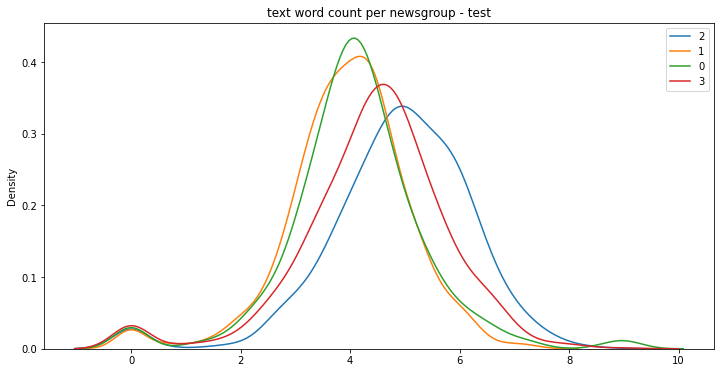

In [5]:
def plot_features_distribution_categories(feature, feature_sel, title, df):
    plt.figure(figsize=(12,6))
    plt.title(title)
    feature_sel_cat = list(df[feature_sel].unique())
    for feature_cat in feature_sel_cat:
        filter_df = df.loc[df[feature_sel] == feature_cat]        
        sns.distplot(filter_df[feature],kde=True,hist=False, bins=120, label=feature_cat)
    plt.xlabel('')
    plt.legend()
    plt.show()
    
plot_features_distribution_categories('text_word_count', 'target', 'text word count per newsgroup - test', df)

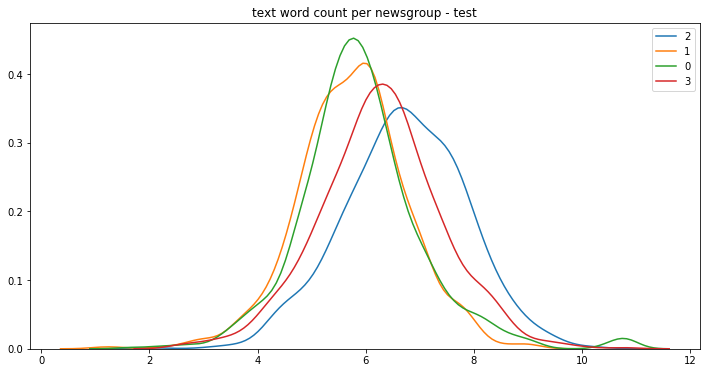

In [6]:
df['text_length'] = df['text'].apply(lambda x: np.log(len(x)))
plot_features_distribution_categories('text_length', 'target', 'text word count per newsgroup - test', df)

In [7]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
def show_wordcloud(feature,df,title="",size=2):
    df[feature] = df[feature].apply(lambda x: ' '.join(simple_preprocess(x)))
    data = df.loc[~df[feature].isnull(), feature].values
    
    count = (~df[feature].isnull()).sum()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(size*4, size*4))
    plt.axis('off')
    fig.suptitle("Top words in {} {} ({} rows)".format(title,feature,count), fontsize=np.sqrt(size)*15)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    



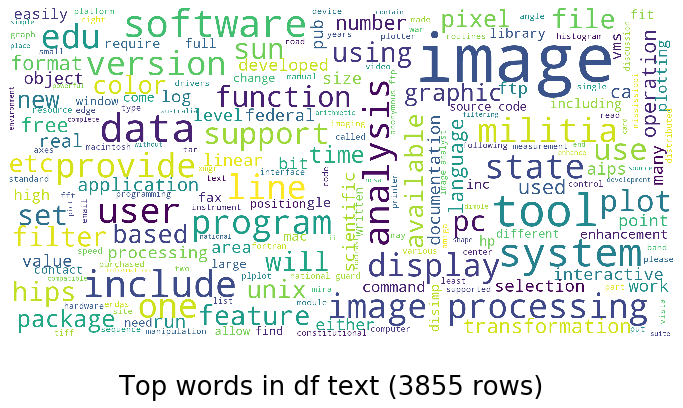

In [8]:
show_wordcloud('text',df, 'df',size=3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


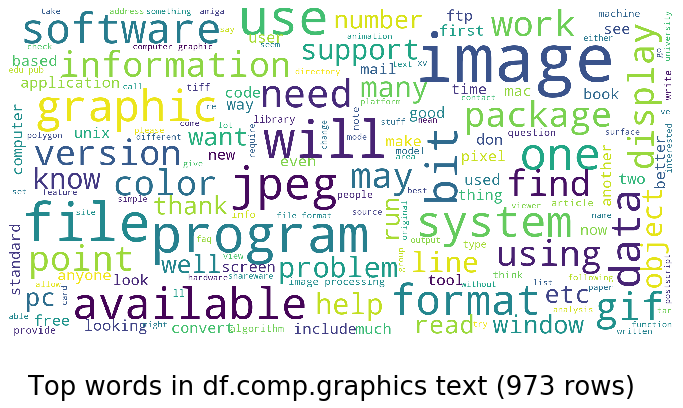

In [9]:
show_wordcloud('text',df.loc[df.target==0], 'df.' + dataset.target_names[0], size=3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


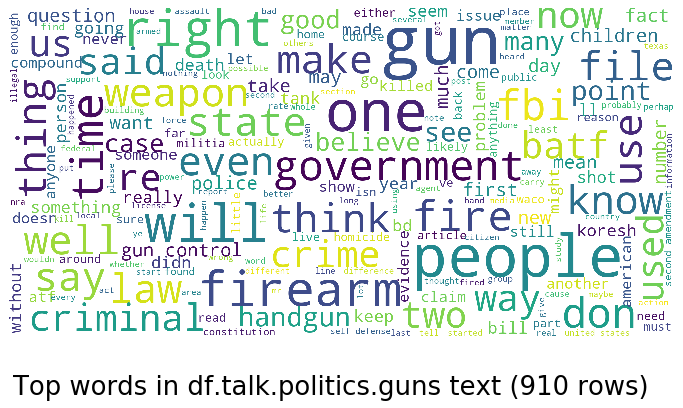

In [10]:
show_wordcloud('text',df.loc[df.target==3], 'df.' + dataset.target_names[3], size=3)

## KMeans + tf_idf

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline


from sklearn.cluster import KMeans

df = df[~(df.text == '')]
labels = df.target
n_components = 4

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df['text'])

print("n_samples: %d, n_features: %d" % X.shape)
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)


km = KMeans(n_clusters=n_components, init='k-means++', max_iter=1000, n_init=1, verbose=False)
km.fit(X)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

n_samples: 3770, n_features: 2000
Performing dimensionality reduction using LSA
Homogeneity: 0.640
Completeness: 0.642
V-measure: 0.641
Adjusted Rand-Index: 0.681
Silhouette Coefficient: 0.428


In [7]:
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]


terms = vectorizer.get_feature_names()
for i in range(n_components):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: gun people don just guns fbi think like government right
Cluster 1: graphics thanks image know file files program format does looking
Cluster 2: god jesus people christ church believe think does know christian
Cluster 3: sale offer new shipping condition edu email interested asking mail


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3770 samples in 0.001s...
[t-SNE] Computed neighbors for 3770 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3770
[t-SNE] Computed conditional probabilities for sample 2000 / 3770
[t-SNE] Computed conditional probabilities for sample 3000 / 3770
[t-SNE] Computed conditional probabilities for sample 3770 / 3770
[t-SNE] Mean sigma: 0.094492
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.595642
[t-SNE] KL divergence after 1000 iterations: 0.933316


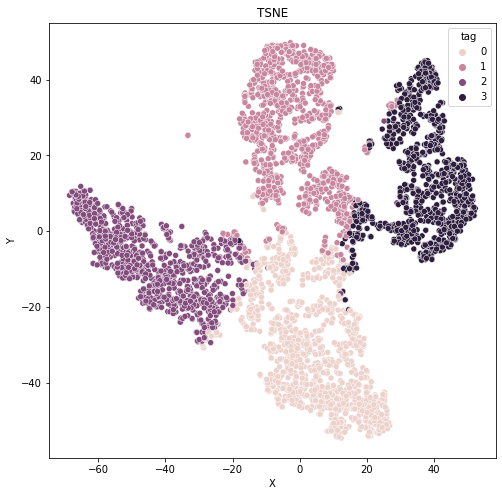

In [8]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 2, perplexity= 50, verbose=1)
tsne_data = tsne.fit_transform(X, y = km.predict(X))
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = km.predict(X)


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

## MiniBatchKMeans + tf-idf

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline


from sklearn.cluster import MiniBatchKMeans

n_components = 4

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df['text'])

print("n_samples: %d, n_features: %d" % X.shape)
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)


km = MiniBatchKMeans(n_clusters=n_components, init='k-means++', max_iter=1000, n_init=1, verbose=False)
km.fit(X)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

n_samples: 3770, n_features: 2000
Performing dimensionality reduction using LSA
Homogeneity: 0.638
Completeness: 0.639
V-measure: 0.638
Adjusted Rand-Index: 0.679
Silhouette Coefficient: 0.441


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3770 samples in 0.001s...
[t-SNE] Computed neighbors for 3770 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3770
[t-SNE] Computed conditional probabilities for sample 2000 / 3770
[t-SNE] Computed conditional probabilities for sample 3000 / 3770
[t-SNE] Computed conditional probabilities for sample 3770 / 3770
[t-SNE] Mean sigma: 0.097094
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.802864
[t-SNE] KL divergence after 1000 iterations: 0.951544


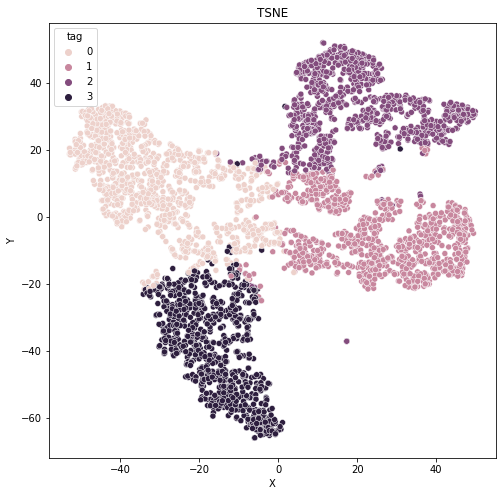

In [10]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 2, perplexity= 50, verbose=1)
tsne_data = tsne.fit_transform(X, y = km.predict(X))
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = km.predict(X)


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

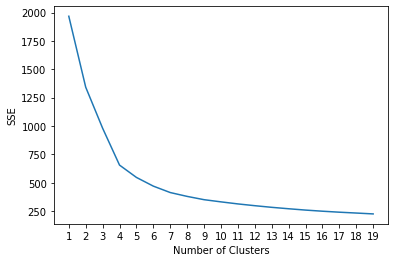

In [11]:
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    

plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Word2Vec + KMeans

In [15]:
from gensim.models import Word2Vec
import nltk
import numpy as np 
from sklearn import cluster
from sklearn import metrics
from nltk import word_tokenize

sentences = df.text.copy

df = df[~(df.text == '')]
labels = df.target
n_components = 4


from gensim.models import Word2Vec
sentences = [word_tokenize(s) for s in df.text.values]

model = Word2Vec(min_count=1)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) 



(2802154, 3499180)

In [16]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    num_word = 0
    for word in sent:
        if num_word == 0:
            sent_vec = model.wv[word]
        else:
            sent_vec = np.add(sent_vec, model.wv[word])
        num_word+=1
    return (np.asarray(sent_vec) / num_word).reshape(1,100)


X = np.zeros(100).reshape(1,100)
for s in sentences:
    X = np.vstack((X, sent_vectorizer(s, model)))
X = np.delete(X, 0, 0)

In [17]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans


n_components = 4
km = KMeans(n_clusters=n_components, 
                     init='k-means++', 
                     max_iter=1000, 
                     n_init=1, 
                     verbose=False)


km.fit(X)



print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.285
Completeness: 0.287
V-measure: 0.286
Adjusted Rand-Index: 0.244
Silhouette Coefficient: 0.203


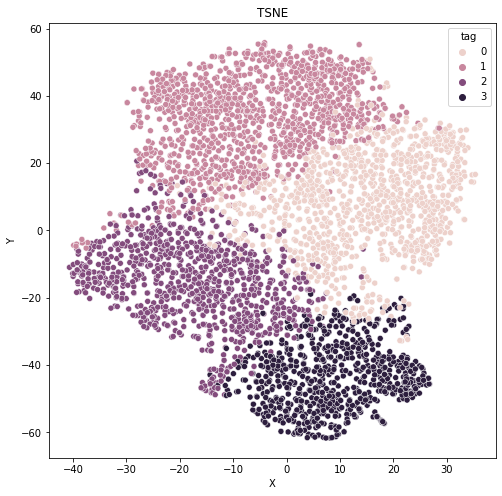

In [18]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 2, perplexity= 50, verbose=0)
tsne_data = tsne.fit_transform(X, y = km.predict(X))
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = km.predict(X)


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

## Word2Vec + DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN()
dbs.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbs.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbs.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbs.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, dbs.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, dbs.labels_, sample_size=1000))

Homogeneity: 0.042
Completeness: 0.079
V-measure: 0.054
Adjusted Rand-Index: 0.048
Silhouette Coefficient: -0.068


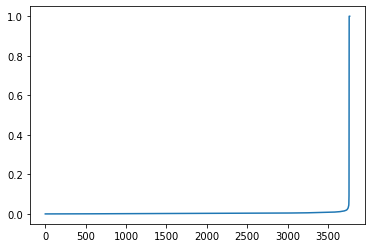

In [99]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=100, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

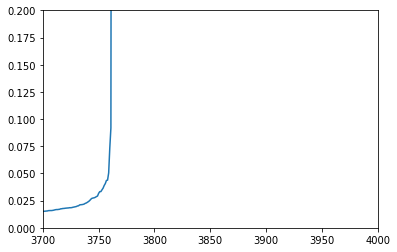

In [100]:
ax = plt.subplot()
plt.xlim(3700, 4000)
plt.ylim(0, 0.2)
ax.plot(distances)

In [101]:
dbs = DBSCAN(eps = 0.025, min_samples = 100, metric = 'cosine')
dbs.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbs.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbs.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbs.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, dbs.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,dbs.labels_, sample_size=1000))

Homogeneity: 0.429
Completeness: 0.496
V-measure: 0.460
Adjusted Rand-Index: 0.330
Silhouette Coefficient: 0.223


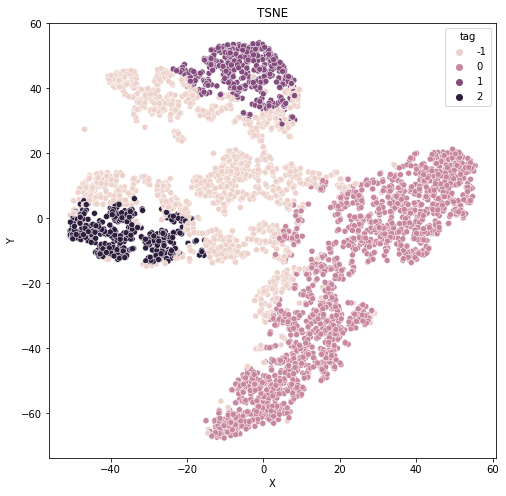

In [102]:
tsne = TSNE(n_components = 2, perplexity= 50, verbose=0)
tsne_data = tsne.fit_transform(X, y = dbs.labels_)
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = dbs.labels_


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

## TFIDF + DBSCAN

In [90]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df['text'])

print("n_samples: %d, n_features: %d" % X.shape)
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

dbs = DBSCAN()
dbs.fit(X)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbs.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbs.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbs.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, dbs.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, dbs.labels_, sample_size=1000))

n_samples: 3770, n_features: 2000
Performing dimensionality reduction using LSA
Homogeneity: 0.000
Completeness: 0.023
V-measure: 0.001
Adjusted Rand-Index: -0.000
Silhouette Coefficient: 0.056


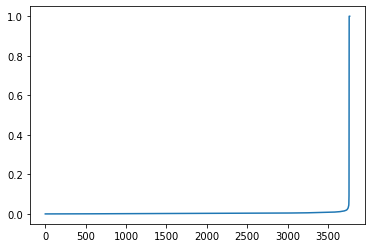

In [103]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=100, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

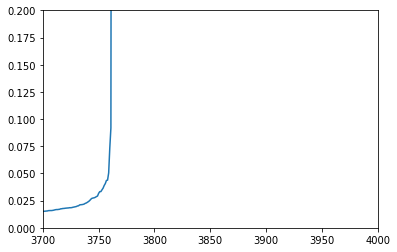

In [104]:
ax = plt.subplot()
plt.xlim(3700, 4000)
plt.ylim(0, 0.2)
ax.plot(distances)

In [105]:
dbs = DBSCAN(eps = 0.03, min_samples = 100, metric = 'cosine')
dbs.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbs.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbs.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbs.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, dbs.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,dbs.labels_, sample_size=1000))

Homogeneity: 0.463
Completeness: 0.512
V-measure: 0.487
Adjusted Rand-Index: 0.375
Silhouette Coefficient: 0.274


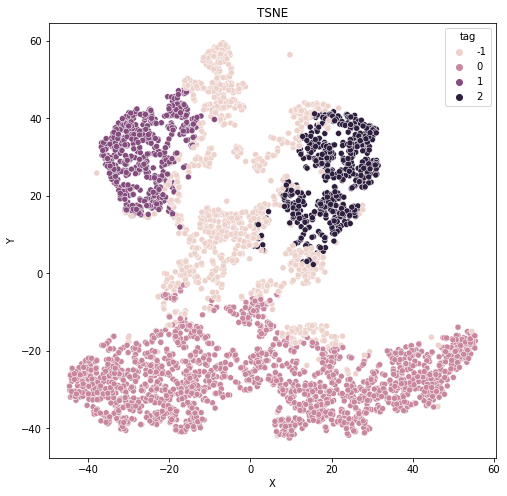

In [106]:
tsne = TSNE(n_components = 2, perplexity= 50, verbose=0)
tsne_data = tsne.fit_transform(X, y = dbs.labels_)
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = dbs.labels_


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

## TFIDF + AgglomerativeClustering

In [114]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=4)
ag.fit_predict(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ag.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ag.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ag.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, ag.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, ag.labels_, sample_size=1000))

Homogeneity: 0.597
Completeness: 0.605
V-measure: 0.601
Adjusted Rand-Index: 0.603
Silhouette Coefficient: 0.409


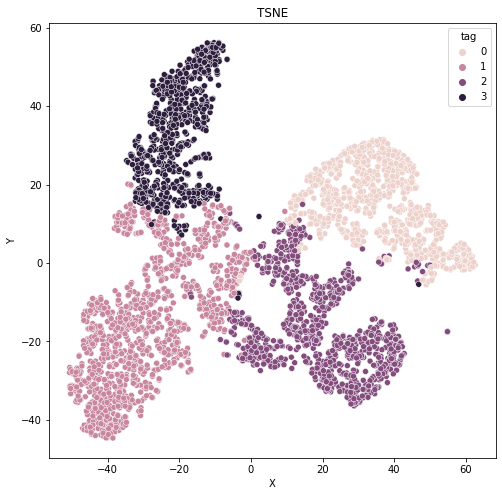

In [115]:
tsne = TSNE(n_components = 2, perplexity= 50, verbose=0)
tsne_data = tsne.fit_transform(X, y = ag.labels_)
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = ag.labels_


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

## Word2Vec + AgglomerativeClustering

In [116]:
X = np.zeros(100).reshape(1,100)
for s in sentences:
    X = np.vstack((X, sent_vectorizer(s, model)))
X = np.delete(X, 0, 0)

ag = AgglomerativeClustering(n_clusters=4)
ag.fit_predict(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ag.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ag.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ag.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, ag.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, ag.labels_, sample_size=1000))

Homogeneity: 0.283
Completeness: 0.312
V-measure: 0.297
Adjusted Rand-Index: 0.249
Silhouette Coefficient: 0.186


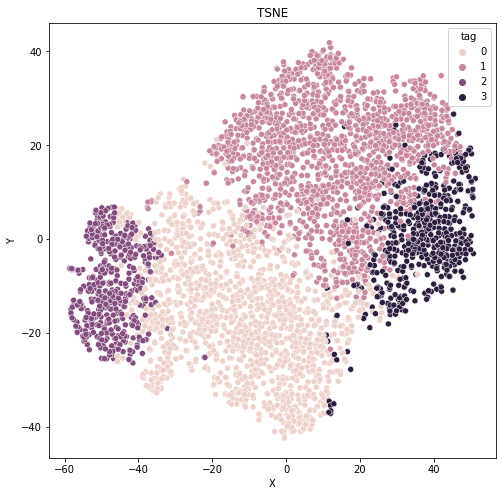

In [117]:
tsne = TSNE(n_components = 2, perplexity= 50, verbose=0)
tsne_data = tsne.fit_transform(X, y = ag.labels_)
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = ag.labels_


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()